In [17]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.api import VAR 

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder,  MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Dropout, Flatten
import tensorflow_probability as tfp
from tensorflow_probability.python.distributions import Normal
tfb = tfp.bijectors
tfd = tfp.distributions

In [4]:
os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [5]:
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_492\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_492\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_492\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\U

In [6]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [7]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [8]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)

In [9]:
data = data.dropna()

# LSTM

In [10]:
def create_sliding_window(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [11]:
def plot_model_rmse_and_loss(history):
    
    #evaluating train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    #val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    #visualizing epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    #plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    #plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

def plot_preds_vs_actual(true, preds):
    plt.figure(figsize=(12,6))
    plt.plot(true, label='Real')
    plt.plot(preds, label='Predicted')
    plt.title('Predicted vs Real Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Aggregated')
    plt.legend()
    plt.show()

In [ ]:
# (1)
#def create_sliding_window(data, window_size):
#    X = []
#    y = []
#    for i in range(len(data)-window_size-1):
#        X.append(data[i:i+window_size])
#        y.append(data[i+window_size])
#    return np.array(X), np.array(y)

In [26]:
#train_split = 0.7
n_train = 35064
n_test = int(len(data)-n_train)
sequence_length = 24

features = ['total_aggregated']
n_features = len(features)
feature_array = data[features].values

# (2)
# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train].reshape(-1,1))

# Transfom on both Training and Test data
scaled_array = target_scaler.transform(feature_array)


X_train, y_train = create_sliding_window(scaled_array[:n_train], sequence_length)
X_test, y_test = create_sliding_window(scaled_array[n_train:], sequence_length)


In [27]:
input_shape = X_train.shape[-2:]

loss = tf.keras.losses.MeanSquaredError()

metric = [tf.keras.metrics.RootMeanSquaredError()]

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

In [28]:
tf.keras.backend.clear_session()

#model building

lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
    #tf.keras.layers.LSTM(64, return_sequences=True),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.LSTM(128, return_sequences=True),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.LSTM(64, return_sequences=True),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.LSTM(32, return_sequences=True),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1),
])

lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)


In [29]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=168) # , callbacks=[early_stopping], validation_data=[X_test, y_test],

Epoch 1/100
209/209 [==============================] - 13s 38ms/step - loss: 0.0776 - root_mean_squared_error: 0.2786
Epoch 2/100
209/209 [==============================] - 8s 40ms/step - loss: 0.0220 - root_mean_squared_error: 0.1482
Epoch 3/100
209/209 [==============================] - 8s 38ms/step - loss: 0.0200 - root_mean_squared_error: 0.1413
Epoch 4/100
209/209 [==============================] - 7s 35ms/step - loss: 0.0189 - root_mean_squared_error: 0.1373
Epoch 5/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0183 - root_mean_squared_error: 0.1351
Epoch 6/100
209/209 [==============================] - 8s 39ms/step - loss: 0.0180 - root_mean_squared_error: 0.1341
Epoch 7/100
209/209 [==============================] - 7s 35ms/step - loss: 0.0176 - root_mean_squared_error: 0.1326
Epoch 8/100
209/209 [==============================] - 7s 36ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327
Epoch 9/100
209/209 [==============================] - 7s 35ms/

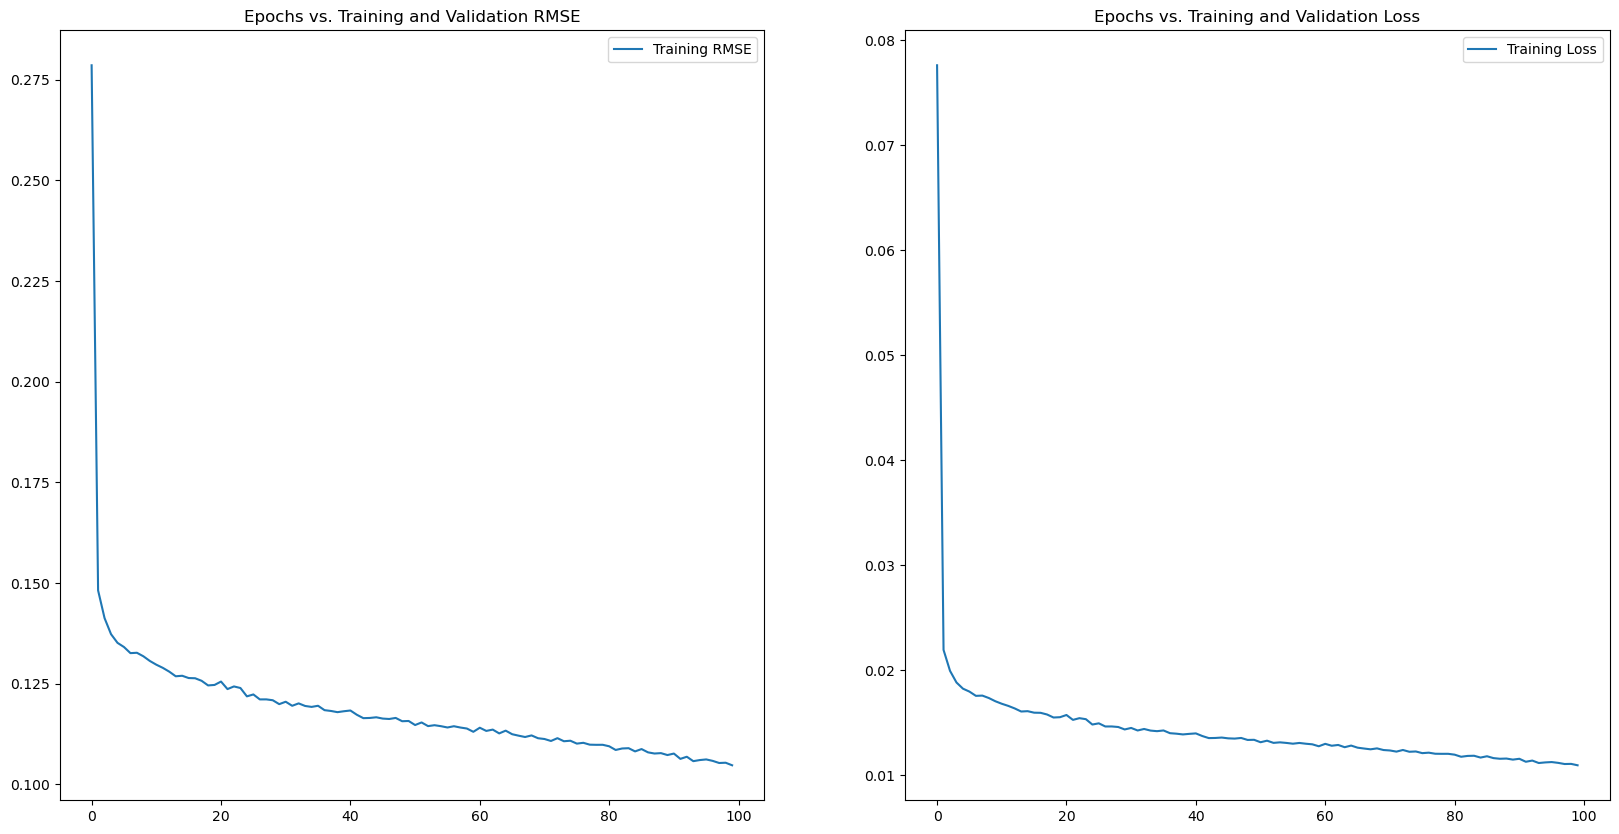

In [30]:
plot_model_rmse_and_loss(history)

In [31]:
predictions = lstm.predict(X_test)
predictions_tot_scaled = target_scaler.inverse_transform(predictions)

548/548 [==============================] - 5s 7ms/step


In [102]:
truth = pd.Series(feature_array[-len(predictions):].flatten())
res=pd.DataFrame()
res['y_true'] = truth
res['y_pred'] = predictions_tot_scaled

rmse_tot = sqrt(np.mean((res.y_true - res.y_pred)**2))
print('Mean Squared Error:', rmse_tot)

Mean Squared Error: 935.4534037577413


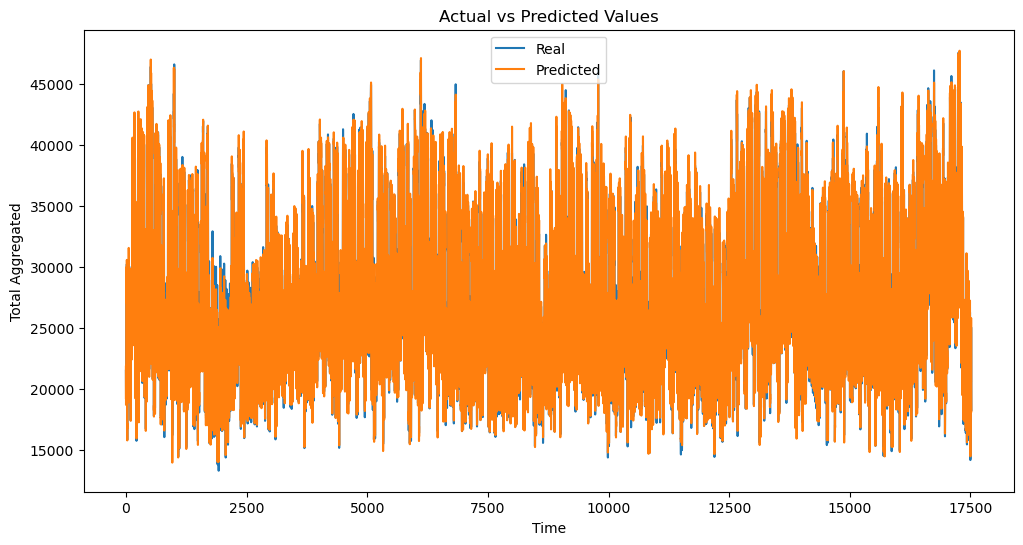

In [33]:
plot_preds_vs_actual(truth, predictions_tot_scaled)

In [ ]:
#scaled_predictions = target_scaler.transform(predictions)
#scaled_truth = target_scaler.transform(truth)
#
#scaled_mse = sqrt(np.mean((scaled_predictions - scaled_truth)**2))
#print('Mean Squared Error:', scaled_mse)

## Forecast with dummy variables for saturday and sunday

In [119]:
#train_split = 0.7
n_train = 35067
n_test = int(len(data)-n_train)

features = ['total_aggregated']
sat = ['saturday']
sun = ['sunday']

feature_array = data[features].values
#dummy = data[we].values
dummy_1 = data[sat].values
dummy_2 = data[sun].values
dummies = [dummy_1, dummy_2]

## concatenate dummy variables with feature_array
#feature_array = np.concatenate((feature_array, dummy_array), axis=1)


In [120]:
# Fit Scaler only on Training target values
target_scaler = StandardScaler()

# Transfom on both Training and Test data
target_scaler.fit(feature_array[:n_train].reshape(-1,1))
scaled_array = target_scaler.transform(feature_array)

In [121]:
# concatenate dummy variables with feature_array
final_array = np.concatenate((scaled_array, dummy_1), axis=1)
final_array = np.concatenate((final_array, dummy_2), axis=1)

In [122]:
sequence_length = 24
#n_features = 3
X, y = create_sliding_window(final_array, sequence_length)

In [123]:
# Then, split into train and test
X_train = X[:n_train]
y_train = y[:n_train, 0]  # Select only the first column (the scaled feature values)

X_test = X[n_train:]
y_test = y[n_train:, 0]  # Select only the first column (the scaled feature values)

In [124]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

In [125]:
tf.keras.backend.clear_session()

#model building

lstm2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, input_shape=input_shape),
    #tf.keras.layers.LSTM(128, return_sequences=True),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.LSTM(64, return_sequences=True),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.LSTM(32, return_sequences=True),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1),
])

lstm2.compile(loss=loss, optimizer=optimizer, metrics=metric)

In [126]:
history2 = lstm2.fit(X_train, y_train, epochs=100, batch_size=168) #validation_data=[X_test, y_test]

Epoch 1/100
209/209 [==============================] - 13s 52ms/step - loss: 0.0731 - root_mean_squared_error: 0.2704
Epoch 2/100
209/209 [==============================] - 8s 40ms/step - loss: 0.0212 - root_mean_squared_error: 0.1455
Epoch 3/100
209/209 [==============================] - 8s 37ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381
Epoch 4/100
209/209 [==============================] - 8s 39ms/step - loss: 0.0185 - root_mean_squared_error: 0.1360
Epoch 5/100
209/209 [==============================] - 7s 35ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346
Epoch 6/100
209/209 [==============================] - 9s 42ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329
Epoch 7/100
209/209 [==============================] - 7s 34ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325
Epoch 8/100
209/209 [==============================] - 7s 36ms/step - loss: 0.0169 - root_mean_squared_error: 0.1302
Epoch 9/100
209/209 [==============================] - 7s 35ms/

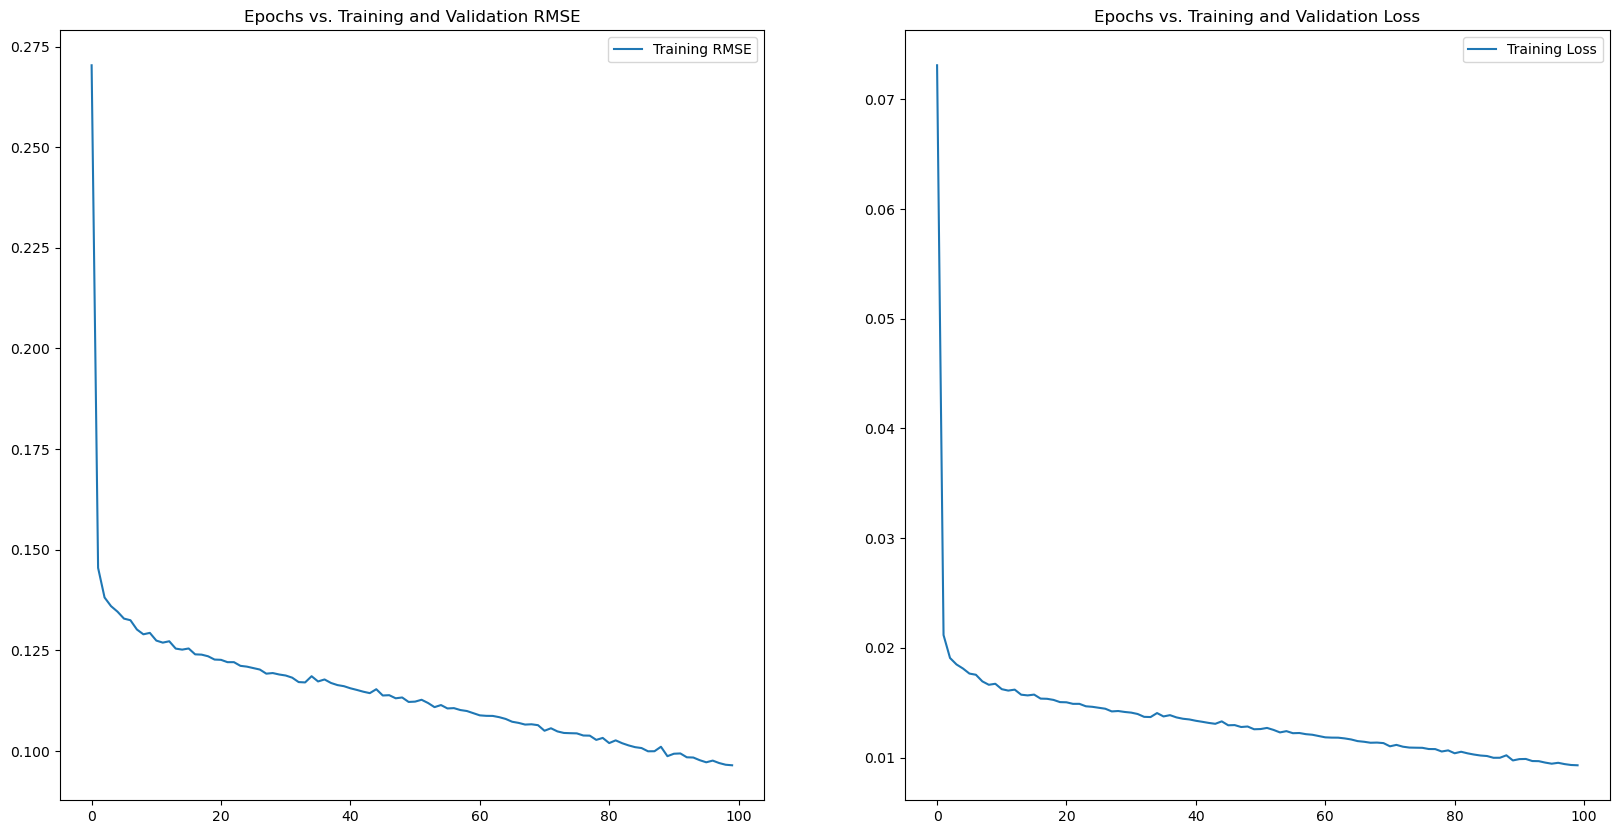

In [127]:
plot_model_rmse_and_loss(history2)

In [128]:

predictions2 = lstm2.predict(X_test)
predictions2_scaled = target_scaler.inverse_transform(predictions2)

548/548 [==============================] - 4s 7ms/step


In [129]:
truth2 = pd.Series(feature_array[-len(predictions2):].flatten())
res2=pd.DataFrame()
res2['y_true'] = truth2
res2['y_pred'] = predictions2_scaled

In [130]:
rmse2 = sqrt(np.mean((res2.y_true - res2.y_pred)**2))
print('Mean Squared Error:', rmse2)

Mean Squared Error: 924.8478189417201


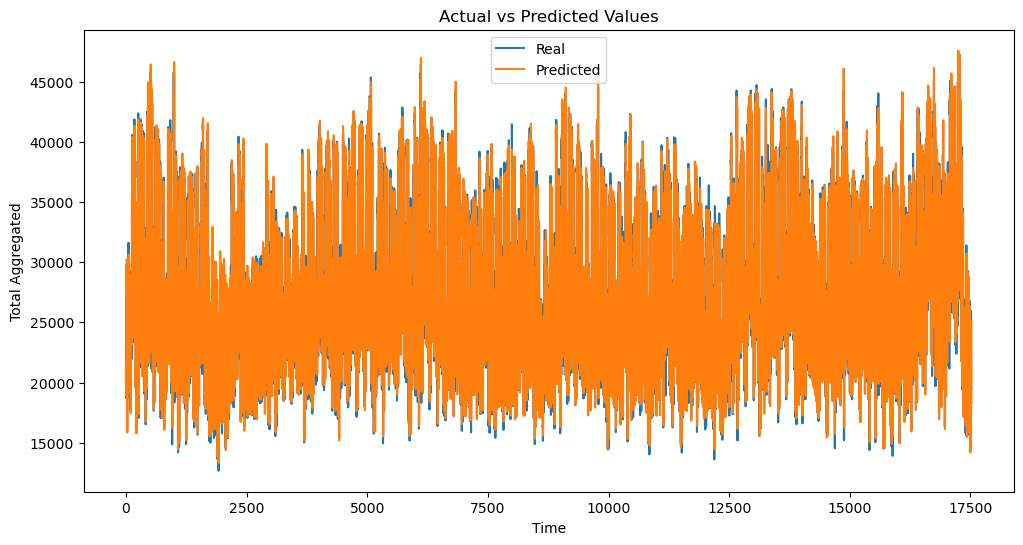

In [131]:
plot_preds_vs_actual(res2.y_pred, res.y_true)

# Forecast with business hour dummy

In [138]:
# il 2020 inizia a inidce 35068

features = ['total_aggregated']
dummy_features = ['business hour']

feature_array = data[features].values
dummy_array = data[dummy_features].values

## concatenate dummy variables with feature_array
#feature_array = np.concatenate((feature_array, dummy_array), axis=1)

# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train].reshape(-1,1))

# Transfom on both Training and Test data
scaled_array = target_scaler.transform(feature_array)

# concatenate dummy variables with feature_array
final_array = np.concatenate((scaled_array, dummy_array), axis=1)

sequence_length = 24
#X_train, y_train = create_sliding_window(final_array[:n_train], sequence_length)
#X_test, y_test = create_sliding_window(final_array[n_train:], sequence_length)


In [139]:
sequence_length = 24
#n_features = 3
X, y = create_sliding_window(final_array, sequence_length)
# Then, split into train and test
X_train = X[:n_train]
y_train = y[:n_train, 0]  # Select only the first column (the scaled feature values)

X_test = X[n_train:]
y_test = y[n_train:, 0]  # Select only the first column (the scaled feature values)

In [140]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

tf.keras.backend.clear_session()

In [141]:
#model building

lstm3 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

lstm3.compile(loss=loss, optimizer=optimizer, metrics=metric)

Epoch 1/100
209/209 [==============================] - 6s 20ms/step - loss: 0.1022 - root_mean_squared_error: 0.3197
Epoch 2/100
209/209 [==============================] - 8s 40ms/step - loss: 0.0268 - root_mean_squared_error: 0.1638
Epoch 3/100
209/209 [==============================] - 7s 35ms/step - loss: 0.0208 - root_mean_squared_error: 0.1441
Epoch 4/100
209/209 [==============================] - 6s 30ms/step - loss: 0.0199 - root_mean_squared_error: 0.1411
Epoch 5/100
209/209 [==============================] - 6s 28ms/step - loss: 0.0188 - root_mean_squared_error: 0.1373
Epoch 6/100
209/209 [==============================] - 6s 27ms/step - loss: 0.0184 - root_mean_squared_error: 0.1355
Epoch 7/100
209/209 [==============================] - 6s 29ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345
Epoch 8/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327
Epoch 9/100
209/209 [==============================] - 6s 29ms/s

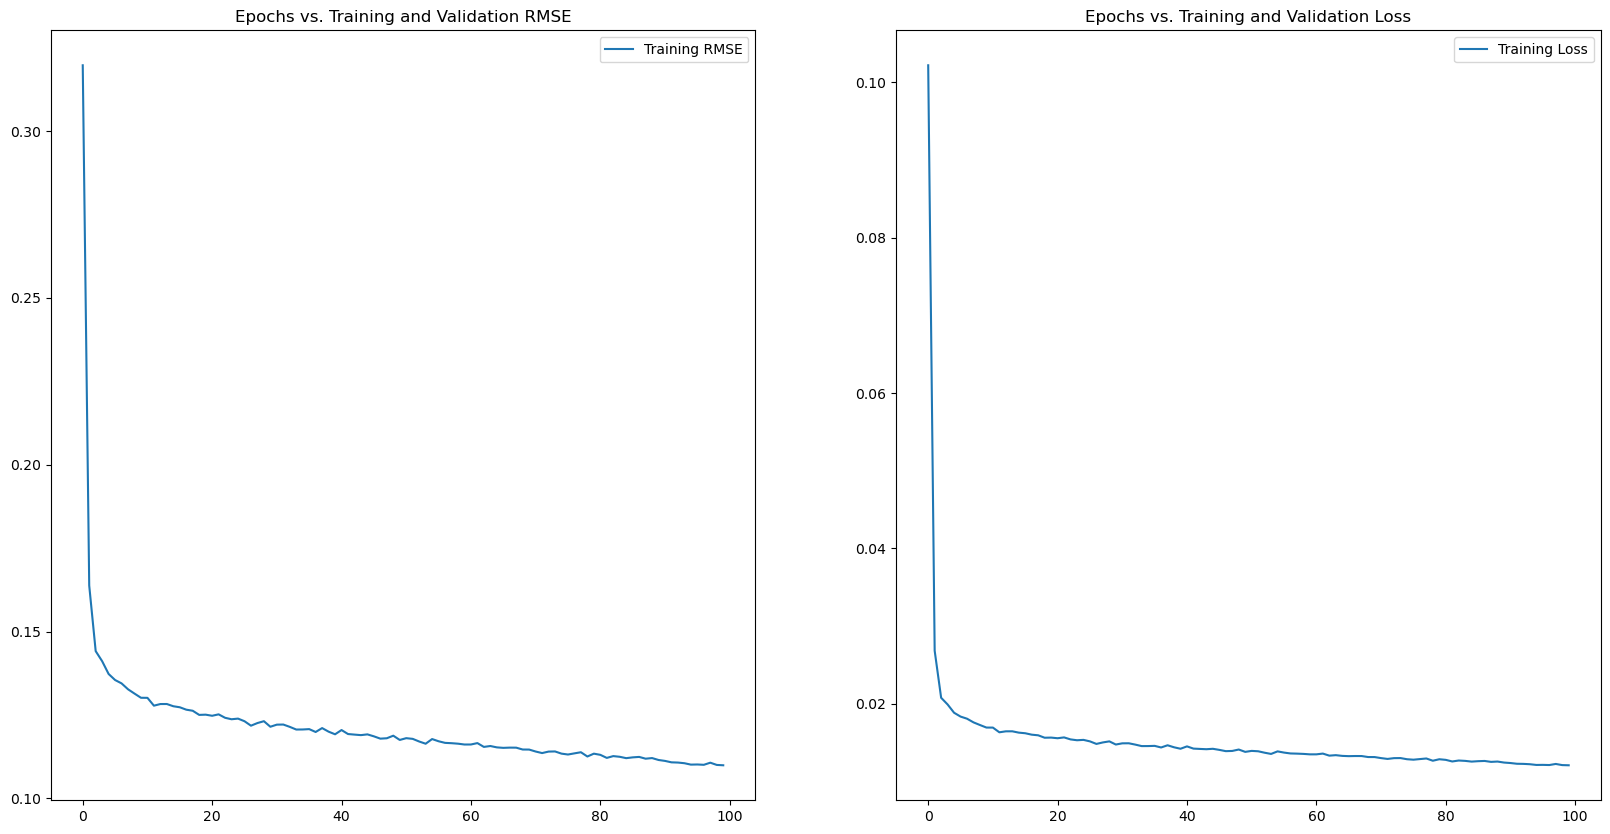

548/548 [==============================] - 5s 7ms/step


In [142]:
history3 = lstm3.fit(X_train, y_train, epochs=100, batch_size=168) #validation_data=[X_test, y_test]
plot_model_rmse_and_loss(history3)

predictions3 = lstm3.predict(X_test)
predictions3_scaled = target_scaler.inverse_transform(predictions3)

In [145]:
res3=pd.DataFrame()
res3['y_true'] = res2['y_true']
res3['y_pred'] = predictions3_scaled
#scaled_predictions = target_scaler.transform(predictions3)
#scaled_truth = target_scaler.transform(truth.reshape(-1,1))
#
mse3 = sqrt(np.mean((res.y_pred - res.y_true)**2))
print('Mean Squared Error:', mse3)

Mean Squared Error: 935.4534037577413


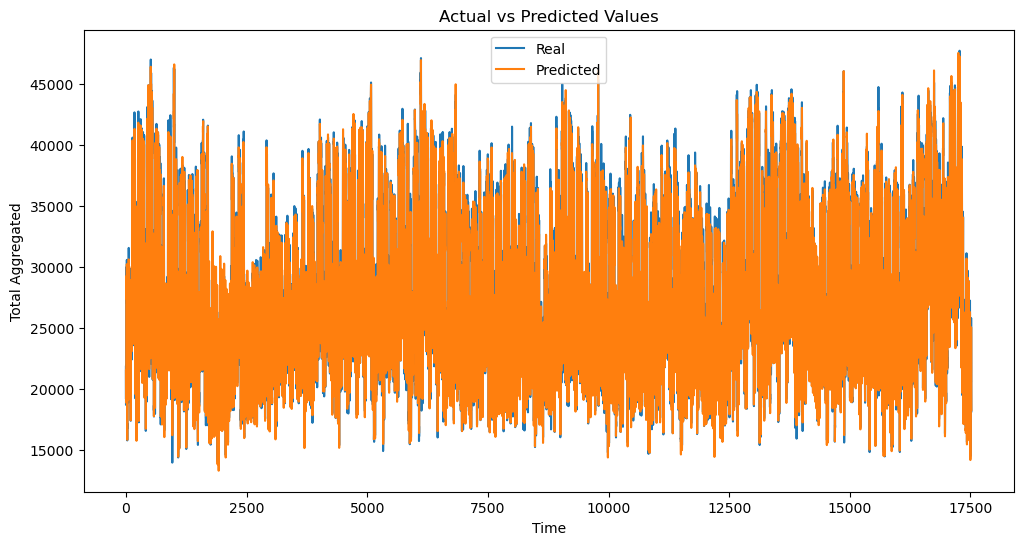

In [146]:
plot_preds_vs_actual(res.y_pred, res.y_true)
